In [11]:
import numpy as np
import torch
import sys
sys.path.append("../")
from Environments.simlple_afl_env import SimpleAFLEnv

In [12]:
NUM_STEPS = 1000

# Create Agent

In [13]:
config_dict = {
    "Action_params": {
        "relative_x_offset_mean": 0.05,
        "relative_x_offset_std": 0.001,
        "relative_y_offset": 0.01,
        "relative_y_offset_std": 0.001,
        "theta_offset_low":  -30,
        "theta_offset_high": 30,
        "number_of_actions": 1
    },
    "Sequence_params": {
        "number_of_states": 1
    },
    "Sensor_params": {
        "num_rays": 200,
        "fov": 180
    },
    "seed": 42

}

rng = np.random.default_rng(
            seed=config_dict["seed"]
        )

## Random Actions
def nh_sample_actions(n_actions: int, rng, action_params: dict) -> torch.tensor:
    relative_x_offset = rng.normal(loc=action_params["relative_x_offset_mean"], scale=action_params["relative_x_offset_std"], size=n_actions)[:,None]
    relative_y_offset = rng.normal(loc=action_params["relative_y_offset_mean"], scale=action_params["relative_y_offset_std"], size=n_actions)[:,None]
    theta_offset = rng.uniform(low=np.deg2rad(action_params["theta_offset_low"]), high=np.deg2rad(action_params["theta_offset_high"]), size=n_actions)[:,None]

    actions = np.concatenate([relative_x_offset, relative_y_offset, theta_offset], axis=-1)
    return torch.from_numpy(actions)

## Potential Field Action Selection
def sample_actions_magnitudes(n_actions: int, rng, action_params: dict, magnitudes: np.ndarray, current_pose: np.ndarray) -> np.ndarray:
    ray_angles = np.linspace(current_pose[-1]-(torch.pi/2), current_pose[-1]+(torch.pi/2), 200)
    magnitudes[:50] = 0
    magnitudes[-50:] = 0
    magnitudes[magnitudes<0.5] = 0

    ray_weights = torch.nn.functional.softmax(torch.from_numpy(magnitudes)*0.5, dim=0)

    direction_idx = rng.choice(200, 1, p=ray_weights)
    action_angle = ray_angles[direction_idx].squeeze()

    if magnitudes.sum() == 0:
        action_length = torch.tensor([0])
    else:
        action_length = rng.normal(loc=action_params["relative_x_offset_mean"], scale=action_params["relative_x_offset_std"], size=n_actions)

    action_vector = np.array(
        [
            np.cos(action_angle), 
            np.sin(action_angle)
        ]
    ).squeeze()

    pose_vector = np.array(
        [
            np.cos(current_pose[-1]), 
            np.sin(current_pose[-1])
        ]
    )

    cross_product = np.cross(pose_vector, action_vector)

    if cross_product < -1:
        cross_product = -1
    elif cross_product > 1:
        cross_product = 1

    angle_diff = np.arcsin(cross_product)

    relative_x_offset = np.cos(angle_diff) * action_length[:,None]
    relative_y_offset = np.sin(angle_diff) * action_length[:,None]
    

    low_array = np.zeros(n_actions)
    high_array = np.zeros(n_actions)

    right_turn_ids = np.where(relative_y_offset < 0)[0]
    left_turn_ids = np.where(relative_y_offset >= 0)[0]

    low_array[right_turn_ids] = np.deg2rad(action_params["theta_offset_low"])
    high_array[left_turn_ids] = np.deg2rad(action_params["theta_offset_high"])
    
    theta_offset = rng.uniform(low=low_array, high=high_array, size=n_actions)[:,None]

    if len(relative_y_offset) >= 2:
        actions = np.concatenate([relative_x_offset, relative_y_offset, theta_offset], axis=-1)
    else:
        actions = np.concatenate([relative_x_offset, relative_y_offset, theta_offset], axis=0)
        
    return actions

# Create Environment

In [14]:
env = SimpleAFLEnv(
    starting_pose=torch.tensor([5, 4, np.deg2rad(10)]),
)
intersection_points, rays, magnitudes, current_pose = env.reset(
    num_rays=config_dict["Sensor_params"]["num_rays"],
    fov=config_dict["Sensor_params"]["fov"]
)

# Sample Sequences from the Environment

In [15]:
pose_list = [current_pose]
beamrs_list = [magnitudes]

## Sample sequences from environment
for i in range(NUM_STEPS):
    ## Sample action
    action = sample_actions_magnitudes(
        n_actions=config_dict["Sequence_params"]["number_of_states"], 
        rng=rng, 
        action_params=config_dict["Action_params"], 
        magnitudes=magnitudes, 
        current_pose=current_pose
    )

    ## apply action to current pose (state) in order to get next pose (next state)
    intersection_points, rays, magnitudes, next_pose = env.step(
        action=torch.from_numpy(action),
        num_rays=config_dict["Sensor_params"]["num_rays"],
        fov=config_dict["Sensor_params"]["fov"]
    )


    current_pose = next_pose
    pose_list.append(current_pose)
    beamrs_list.append(magnitudes)


pose_seq = np.array(pose_list)
beamrs_seq = np.array(beamrs_list)

# Plot Environment

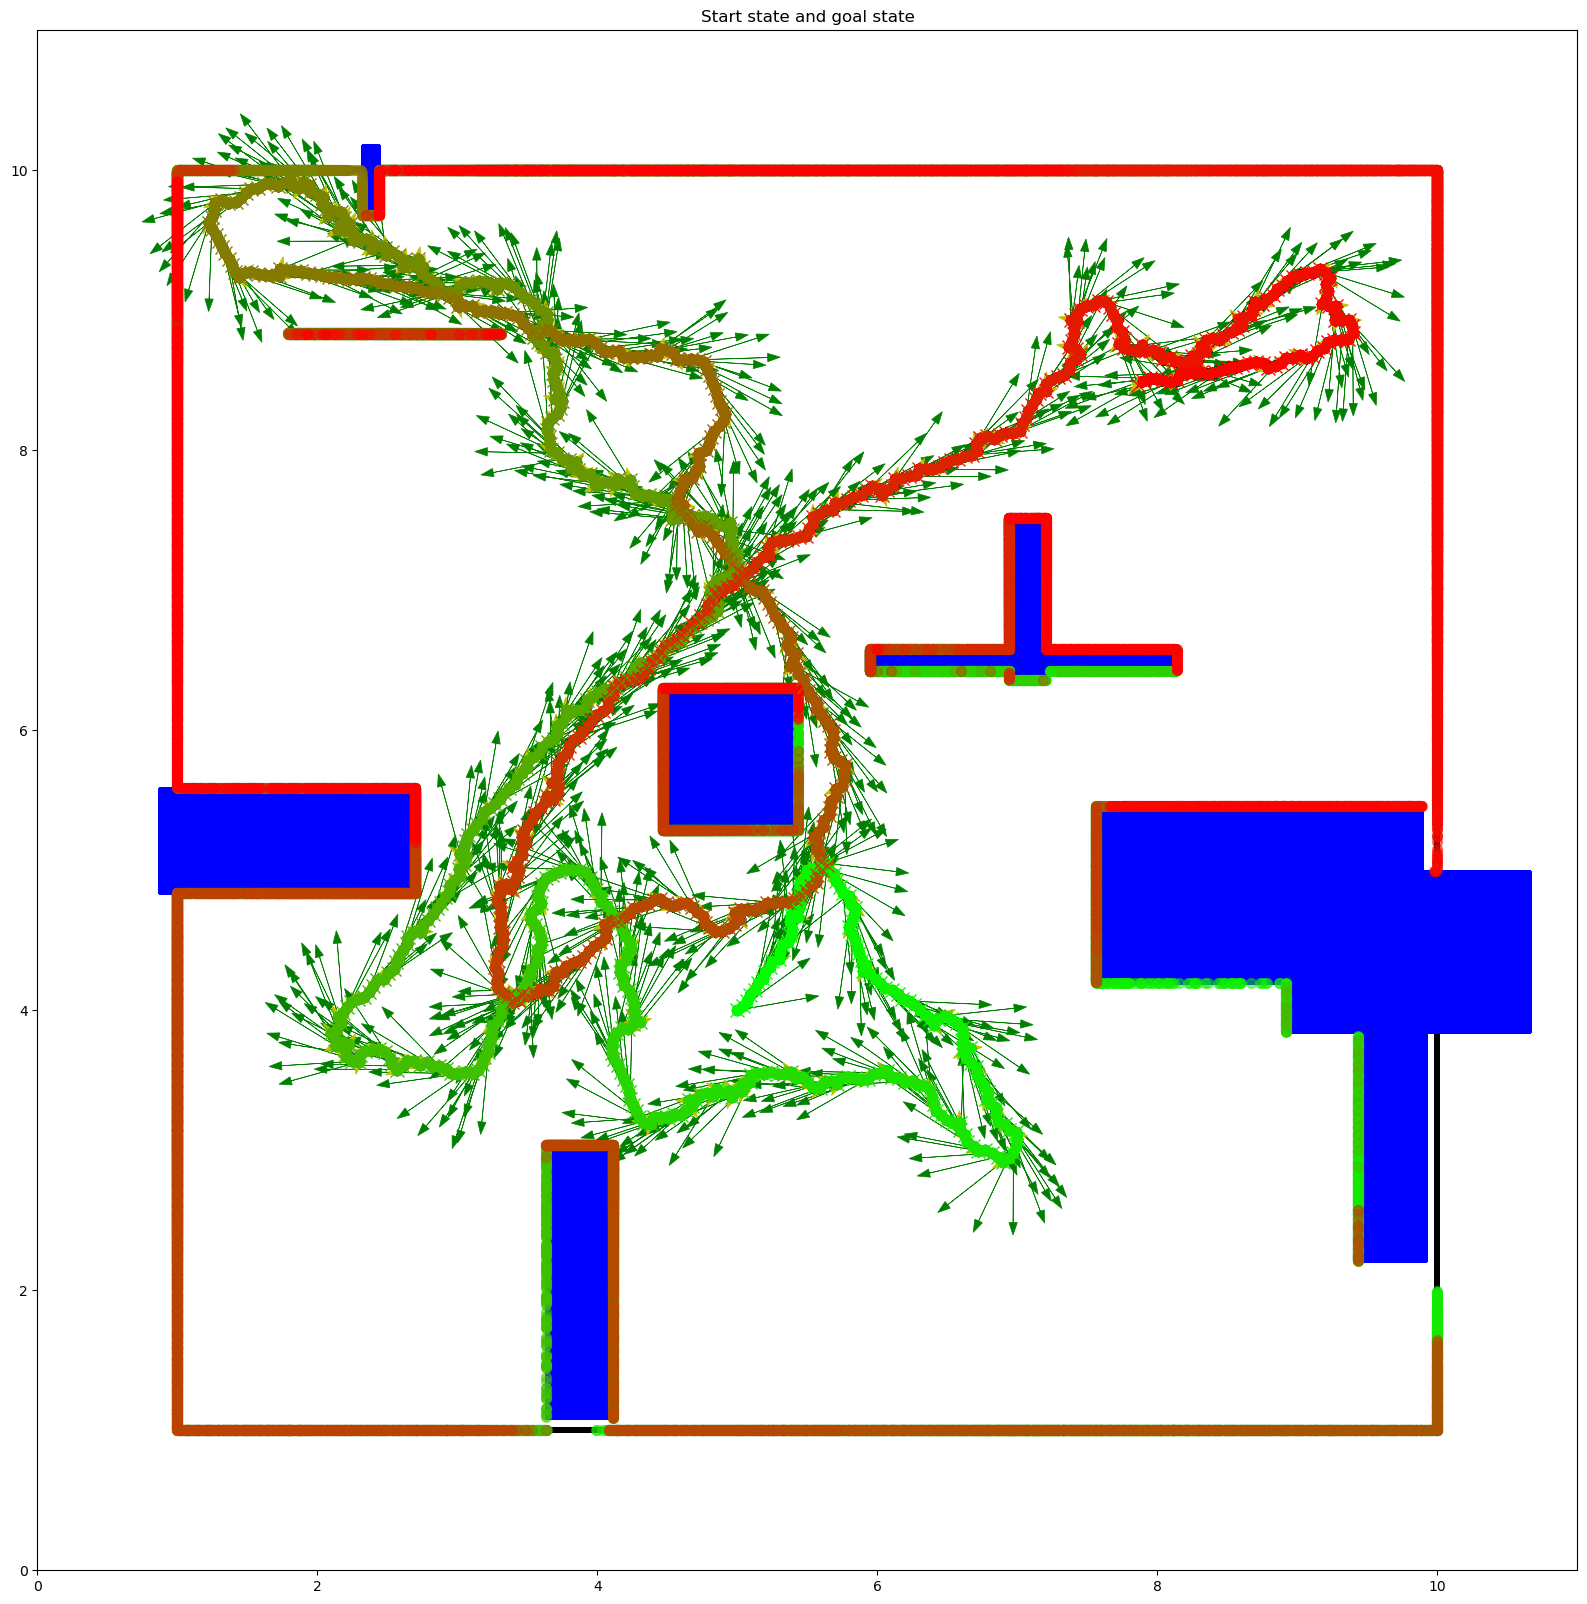

In [16]:
data_dict = {
    "x": pose_seq[:,0],
    "y": pose_seq[:,1],
    "t": pose_seq[:,2],
    "si": beamrs_seq
}

samples = beamrs_seq.shape[0]
plot_beams = True
text = "Start state and goal state"

env.plot_env(text, samples, data_dict, plot_beams, 0.5)

In [ ]:
# TODO: Parameterize BeamDataVisualizer to take on the obstacle positions as arguments
# TODO: Environment must check whether actions are valid or not